(ch6:joint)=
# Joint Representation Learning

In many problems, your network might be more than just the information contained in its adjacency matrix (called its **network topology**, or its collection of nodes and edges). If you were investigating a social network, you might have access to extra information about each person -- their gender, for instance, or their age. If you were investigating a brain network, you might have information about the physical location of neurons, or some notion of how big a brain region is. When you embed a network, it seems like you should be able to use these extra bits of information - called the "features" or "covariates" of a network - to somehow improve your analysis. The techniques and tools that you'll explore in this section use both the covariates and the topology of a network to create and learn from new representations of the network. Because they jointly use both the topology of the network and its extra covariate information, these techniques and tools are called joint representation learning.

There are two primary reasons that you might want to explore using node covariates in addition to topological structure. First, they might improve your standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. For example, if the latent structure of the covariates of a network lines up with the latent structure of its topology, then you might be able to reduce noise when you embed, even if the communities in your network don't overlap perfectly with the communities in your covariates. Second, figuring out what the clusters of an embedding actually mean can sometimes be difficult and covariates create a natural structure in your network that you can explore. Covariate information in brain networks telling you where in the brain each node is, for instance, might let us better understand the types of characteristics that distinguish between different brain regions.

In this section, you'll explore different ways to learn from your data when you have access to the covariates of a network in addition to its topological structure. You'll explore *Covariate-Assisted Spectral Embedding* (CASE), a variation on Spectral Embedding developed by {cite:p}`Binkiewicz2017Jun`. In CASE, instead of embedding just the adjacency matrix or its Laplacian, you'll combine the Laplacian and your covariates into a new matrix and embed that.

A good way to illustrate how using covariates might help us is to use a model in which some of your community information is in the covariates and some is in your topology. Using the Stochastic Block Model from {numref}`ch5:sbm`, we’ll create a simulation using three communities: the first and second community will be indistinguishable in the topological structure of a network, and the second and third community will be indistinguishable in the covariates. By combining the topology and the covariates, you'll get a nice embedding that lets you find three distinct community clusters.

### Stochastic Block Model

To illustrate the value of this technique, we'll turn to another social network example. Suppose that you have $150$ nodes in your network representing students who attend one of three schools. The first $50$ students attend school $1$, the second $50$ students attend school $2$, and the third $50$ students attend school $3$. Edges of your adjacency matrix represent whether a pair of individuals are friends or not. You want to be able to identify which school each individual is from, but you have a problem that differentiates this situation from the traditional stochastic block model setting.

As it turns out, the first two schools are located in the same area, but the students tend to keep to themselves between schools. In this sense, the probability that two students are friends if they are both from the same school will be relatively high, but the probability that two students are friends if they are from different schools is low. On the other hand, the second and third schools are not co-ed: they are religious schools which provide education for students who identify as male or female separately. These students have a "brother/sister" relationship: all of their social events and school functions are performed jointly. Pairs of students who attend these two schools, it turns out, have a relatively similar chance of being friends regardless of which school they attend.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)

In [4]:
import numpy as np
from graspologic.simulations import sbm

# Start with some simple parameters
N = 150  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[.3, .1, .1],
              [.1, .3, .25],
              [.1, .25, .3]])  # your block probability matrix

# Make your Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)
labels = labels + 1  # offset so 1:3 and not 0:2

Here you can see what your adjacency matrix looks like. Notice the giant block in the bottom-right: this block contains nodes in both of the second two communities, and they don't look too indistinguishable even though the adjacency matrix has been sorted by community.

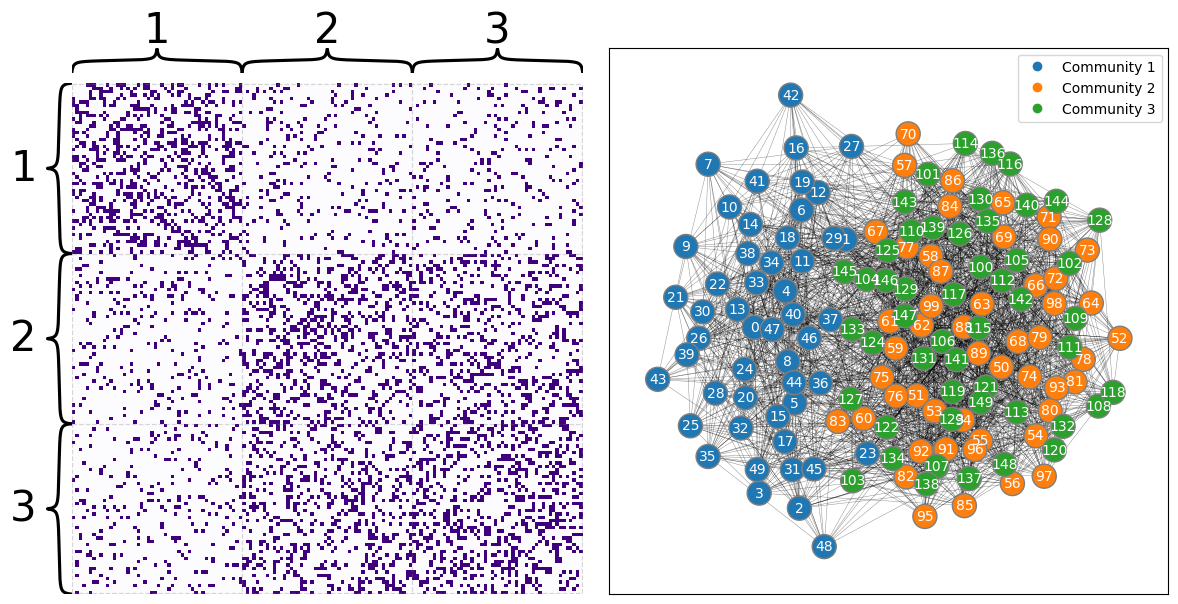

In [5]:
import matplotlib.pyplot as plt
from graphbook_code import draw_multiplot
import matplotlib

draw_multiplot(A, labels=labels);

If you wanted to embed this network using your Laplacian or Adjacency Spectral Embedding methods, you'd find the second and third communities layered on top of each other (though you wouldn't be able to figure that out from your embedding if you didn't cheat by knowing in advance which community each node is supposed to belong to). The python code below embeds your latent positions all the way down to two dimensions. Below it, you can see a plot of the latent positions, with each node color-coded by its true community (which is, as far as you know up to this point in your analysis, unknown).

In [8]:
from graspologic.embed import LaplacianSpectralEmbed as LSE

L_latents = LSE(n_components=2).fit_transform(A)

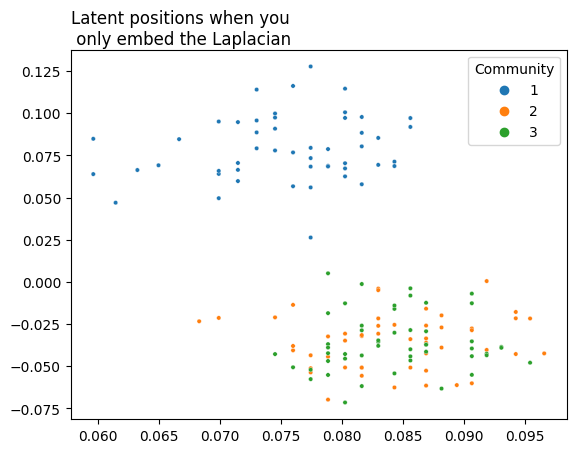

In [9]:
import seaborn as sns
from graphbook_code import plot_latents

plot = plot_latents(L_latents, title="Latent positions when you\n only embed the Laplacian", 
                    labels=labels)

As you can see, you'd have a tough time learning from this - the second and third community are completely indistinguishable. It would be nice if you could use extra information to more clearly distinguish between them. You don't have this information in your adjacency matrix: it needs to come from somewhere else.

### Covariates

But you're in luck - you have a set of covariates for each node! These covariates contain the extra information you need that allows you to separate your first and second community. However, with only these extra covariate features, you can no longer distinguish between the second and third communities - they are similar in their covariates.

Below is Python code that generates these covariates. Each node is associated with its own group of 2 covariates. You'll organize this information into a matrix, where the $i^{th}$ row contains the covariates associated with node $i$. Remember that you have 150 nodes in your network, so there will be 150 rows. You'll draw all the covariates at random, but the nodes in the third community will be drawn from a different distribution than the nodes in the last two. 

In [14]:
from scipy.stats import beta

def make_community(a, b, n=int(N/3)):
    return [3, 1] * beta.rvs(a, b, size=(n, 2))

def gen_covariates():
    c1 = make_community(5, 2)
    c2 = make_community(5, 2)
    c3 = make_community(2, 5)

    covariates = np.vstack((c1, c2, c3))
    return covariates
    

# Generate a covariate matrix
Y = gen_covariates()

Here is a visualization of the covariates you just created. The first community is represented by the lighter-colored rows, and the last two are represented by the darker-colored rows.

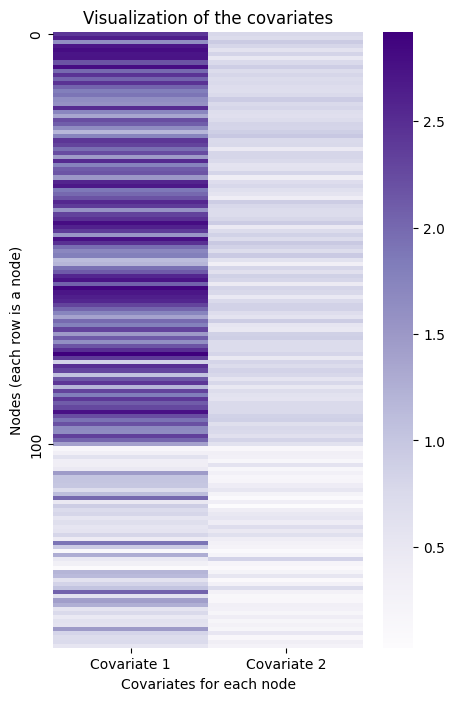

In [15]:
from graphbook_code import GraphColormap, heatmap

# Plot and make the axis look nice
cmap = GraphColormap("sequential", discrete=False).palette
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.heatmap(Y, ax=ax, cmap=cmap, yticklabels=100)
ax.set(title="Visualization of the covariates", 
       ylabel="Nodes (each row is a node)",
       xlabel="Covariates for each node",
       xticks=[0.5, 1.5], xticklabels=["Covariate 1", "Covariate 2"]);

You can play almost the same game here as you did with the Laplacian. If you embed the information contained in this matrix of covariates into lower dimensions, you can see the reverse situation as before - the third community is separate, but the first two are overlayed on top of each other.

Below is Python code that embeds the covariates. You'll use custom embedding code rather than graspologic's LSE class, because it isn't technically right to act as if you're embedding a Laplacian (even though you're doing essentially the same thing under the hood). Underneath it is a plot of the resulting embedding.

In [25]:
from sklearn.utils.extmath import randomized_svd

def embed(matrix, *, dimension):
    latents, s, _ = randomized_svd(matrix, n_components=dimension)
    return latents @ np.diag(np.sqrt(s))

Y_latents = embed(Y, dimension=2)

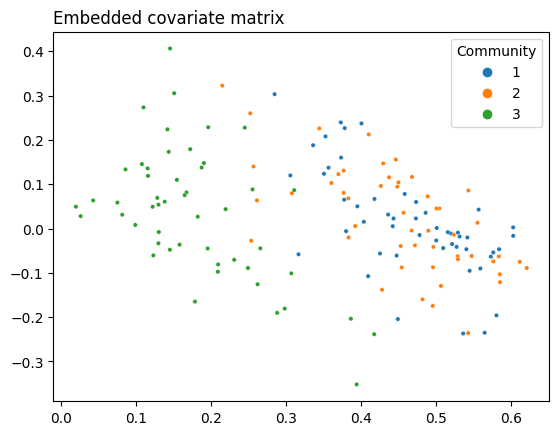

In [26]:
plot = plot_latents(Y_latents, title="Embedded covariate matrix", 
                    labels=labels)

As you can see, you're in a similar situation as you were in with the adjacency matrix, but with different communities: instead of the second and third communities being indistinguishable, now the first and second are. You'd like to see full separation between all three communities, so you need some kind of representation of your network that allows you to use both the information in the topology and the information in the covariates. This is where CASE comes in.

## Covariate-Assisted Spectral Embedding

*Covariate-Assisted Spectral Embedding*, or CASE, is a simple way of combining your network and your covariates into a single model. In the most straightforward version of CASE, you combine the network's Laplacian $L$ and a function of your covariate matrix $YY^\top$. Here, $Y$ is just your covariate matrix, in which row $i$ contains the covariates associated with node $i$. You can go back to {numref}`ch4:matrix-rep` to refamiliarize yourself with the Laplacian.

```{note}
Suppose that $Y$ only contains 0's and 1's. To interpret $YY^top$, notice you're effectively taking the the dot product of each row of $Y$ with each other row, because the transpose operation turns rows into columns. Now, look at what happens below when you take the dot product of two example vectors with only 0's and 1's in them:

\begin{align}
\begin{bmatrix}
1 & 1 & 1
\end{bmatrix} \cdot 
\begin{bmatrix}
0 \\
1 \\
1 \\
\end{bmatrix} = 1\times 0 + 1\times 1 + 1\times 1 = 2
\end{align}

If there are two overlapping 1's in the same position of the left vector and the right vector, then there will be an additional 1 added to their weighted sum. So, in the case of a binary $YY^T$, when you matrix-multiply a row of $Y$ by a column of $Y^T$, the resulting value, $(YY^T)_{i, j}$, will be equal to the number of shared locations in which vectors $i$ and $j$ both have ones.

This logic extends to when the matrix isn't just ones and zeros too: the value of $YY^\top$ will be greater for a pair of nodes $i$ and $j$ when they have similar values, and smaller when they have less similar values.
```

A particular value in $YY^\top$, $(YY^\top)_{i, j}$, can be interpreted as measuring the "agreement" or "similarity" between row $i$ and row $j$ of your covariate matrix. Since each row represents the covariates for a particular node, the higher the value of $(YY^\top)_{i, j}$, the more similar the covariates of the $i_{th}$ and $j_{th}$ nodes are. The overall result is a matrix that looks fairly similar to your Laplacian!  

The following Python code generates your covariate similarity matrix $YY^\top$ Later, you'll weight $YY^\top$ to help with normalization issues.

In [27]:
YYt = Y@Y.T

Below, you can see the Laplacian you generated earlier next to $YY^\top$. Remember, each matrix contains information about your communities that the other doesn't have - and your goal is to combine them in a way that lets you distinguish between all three communities.

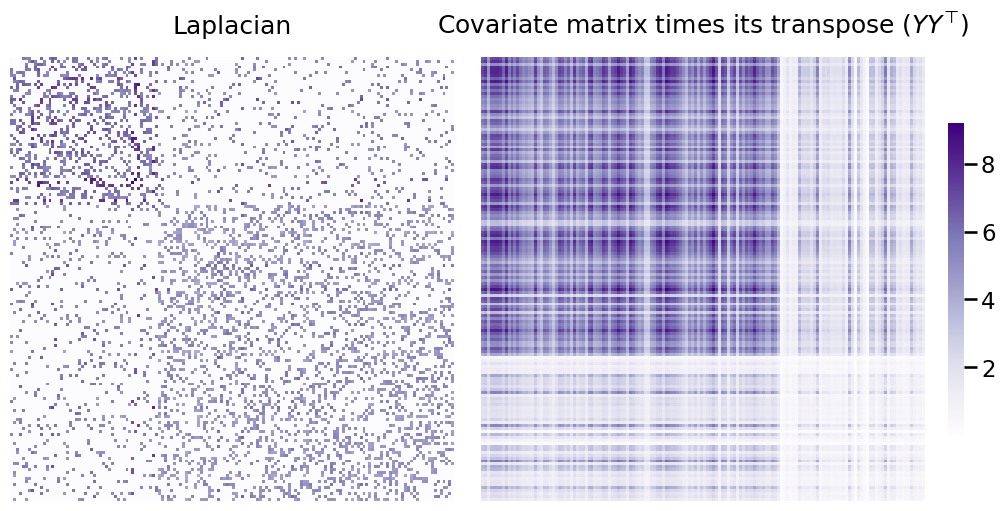

In [28]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)
L_ax = heatmap(L, title=r"Laplacian", ax=axs[0], cbar=False)
X_ax = heatmap(YYt, title=r"Covariate matrix times its transpose ($YY^\top$)", ax=axs[1]);

The way we'll combine the two matrices will simply be a weighted sum of these two matrices - this is what CASE is doing under the hood. The weight (here called $\alpha$) is multiplied by $YY^\top$ - that way, both matrices contribute an equal amount of useful information to the embedding. 

$$
L + \alpha YY^\top
$$

### Exploring Possible Weights

An obviuos question here is how to weight the covariates. If you simply summed the two matrices by themselves, you'd unfortunately be in a situation where whichever matrix contained larger numbers would dominate over the other. In your current setup, without a weight on $YY^\top$, the covariates of your network would dominate over its topology.

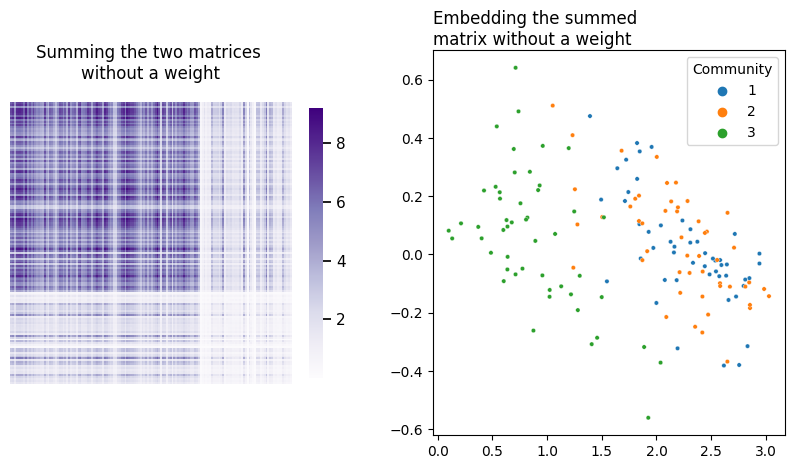

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
heatmap(L + Y@Y.T, title="Summing the two matrices \nwithout a weight", ax=axs[0], context='notebook');
plot_latents(embed(L + Y@Y.T, dimension=2), title="Embedding the summed \nmatrix without a weight", 
             ax=axs[1], labels=labels);

What do different potential weights look like? Let's do a comparison. Below you can see the embeddings for 9 possible weights on $YY^\top$, ranging between $10^{-5}$ and 100.

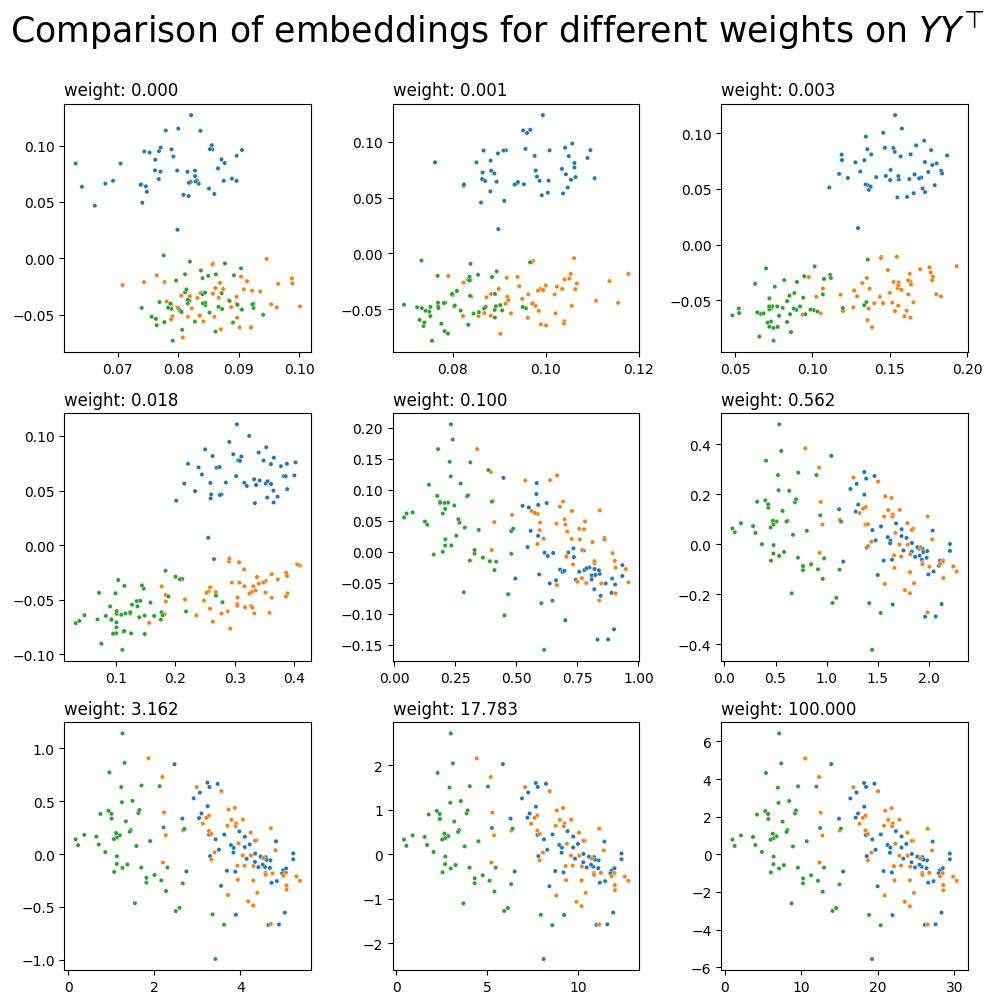

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for a, ax in zip(np.geomspace(10e-5, 100, num=9), axs.flat):
    l_ = embed(L+a*YYt, dimension=2)
    plot_latents(l_, title=f"weight: {a:.3f}", labels=labels, ax=ax)
    ax.get_legend().remove()

fig.suptitle(r"Comparison of embeddings for different weights on $YY^\top$", y=1, fontsize=25);
plt.tight_layout()

It looks like you'd probably want a weight somewhere between 0.003 and 0.018  - then, you'll have three communities which are fairly distinct from each other, implying that you're pulling good information from both your network's topology and its covariates. You could just pick your weight manually, but it would be nice to have some kind of algorithm or equation which lets you pick a reasonable weight automatically.

### Finding a Reasonable Weight Automatically

In general, you'd like to embed in a way that lets you distinguish between communities. This means that if you knew which community each node belonged to, you'd like to be able to correctly retrieve the correct commmunities for each node as possible with a clustering algorithm after embedding. This also implies that the communities will be as distinct as possible.

You already found a range of possible weights, embedded your combined matrix for every value in this range, and then looked at which values produced the best clustering. But, how do you find a weight which lets you consistently use useful information from both the topology and the covariates?

When you embed symmetric matrices, keep in mind that the actual points you're plotting are the components of the eigenvectors with the biggest eigenvalues. When you embed into two-dimensional space, for instance, the X-axis values of your points are the components of the eigenvector with the biggest eigenvalue, and the Y-axis values are the components of the eigenvector with the second-biggest eigenvalue. This means that you should probably be thinking about how much information the Laplacian and $YY^\top$ contributes to the biggest eigenvalue/eigenvector pairs. 

Thinking about this more, if you have a small weight, $YY^\top$ will contribute only a small amount to the biggest eigenvalue/vector pair. If you have a large weight, $YY^\top$ will contribute a large amount to the biggest eigenvalue/vector pair. The weight that causes the Laplacian and $YY^\top$ to contribute the same amount of information, then, is just the ratio of the biggest eigenvalue of $L$ and the biggest eigenvalue of $YY^\top$:

$$
weight = \frac{\lambda_1 (L)}{\lambda_1 (YY^\top)}
$$

Let's check what happens when you combine your Laplacian and covariates matrix using the weight described in the equation above. Your embedding works the same as it does in Laplacian Spectral Embedding: you decompose your combined matrix using Singular Value Decomposition, truncating the columns, and then you visualize the rows of the result. Remember, you'll be embedding $L + \alpha YY^\top$, where $\alpha$ is your weight. You'll embed all the way down to two dimensions, just to make visualization simpler.

In [33]:
from scipy.sparse.linalg import eigsh

# Find the biggest eigenvalues in both of your matrices
leading_eigval_L, = eigsh(L, return_eigenvectors=False, k=1)
leading_eigval_YYt, = eigsh(YYt, return_eigenvectors=False, k=1)

# Per your equation above, you get the weight using
# the ratio of the two biggest eigenvalues.
weight = leading_eigval_L / leading_eigval_YYt

# Do your weighted sum, then embed
L_ = L + weight*YYt
latents_ = embed(L_, dimension=2)

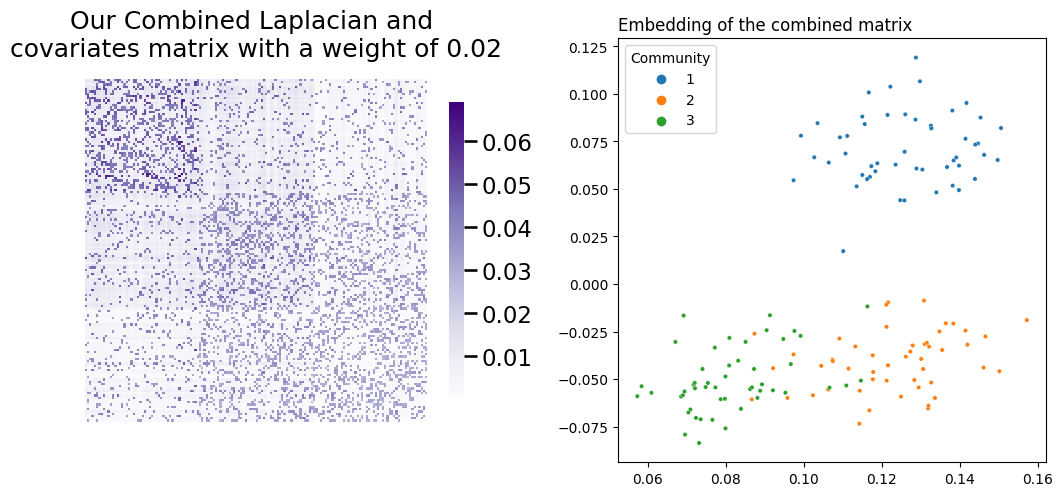

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
heatmap(L_, title=f"Our Combined Laplacian and \ncovariates matrix with a weight of {weight:.2f}", ax=axs[0])
plot_latents(latents_, 
             title=f"Embedding of the combined matrix", 
             labels=labels, ax=axs[1]);

plt.tight_layout()

Success! You've managed to achieve separation between all three communities. Below you can see (from left to right) a comparison of your network's latent position when you only use its topological information, when you only use the information contained in its covariates, and finally your embedding using the weight you found.

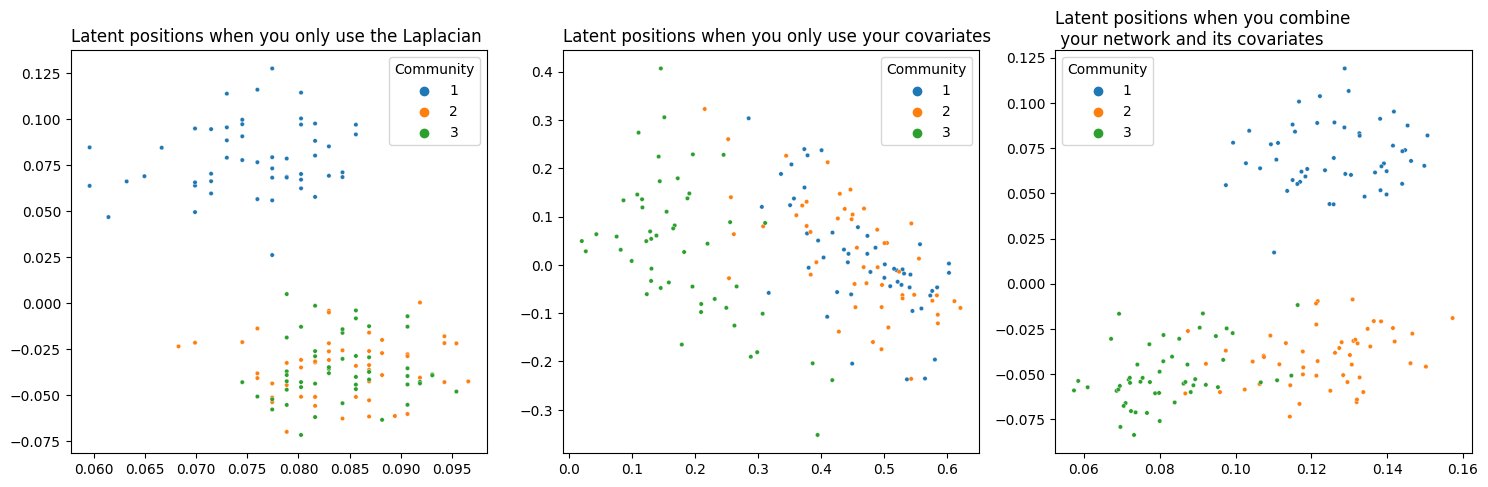

In [35]:
from graspologic.embed import LaplacianSpectralEmbed as LSE


# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_latents(L_latents, title="Latent positions when you only use the Laplacian", 
             labels=labels, ax=axs[0])
plot_latents(Y_latents, title="Latent positions when you only use your covariates", 
             labels=labels, ax=axs[1]);
plot_latents(latents_, title="Latent positions when you combine\n your network and its covariates", 
             labels=labels, ax=axs[2])

plt.tight_layout()

### Using Graspologic

Graspologic's `CovariateAssistedSpectralEmbedding` class implements CASE directly. The following code applies CASE to reduce the dimensionality of $L + aYY^T$ down to two dimensions, and then plots the latent positions to show the clustering. 

```{admonition} Non-Assortative Networks 
You don't always necessarily want to embed $L + \alpha YY^\top$. Using the Laplacian by itself might not always be ideal. If your network is *non-assortative* - meaning, the between-block probabilities are greater than the within-block probabilities - it's better to square your Laplacian. This is because the adjacency matrices of non-assortative networks have a lot of negative eigenvalues; squaring the Laplacian gets rid of a lot of annoying negative eigenvalues, and you end up with a better embedding. In the non-assortative case, you end up embedding $LL + aYY^\top$. The `embedding_alg` parameter controls this: you can write `embedding_alg="non-assortative"` if you're in the non-assortative situation.
```

In [ ]:
from graspologic.embed import CovariateAssistedEmbed as CASE

casc = CASE(assortative=True, n_components=2)
latents = casc.fit_transform(A, covariates=Y)
plot_latents(latents, title="Embedding your model using graspologic", labels=labels);

## Omnibus Joint Embedding

If you've read the Multiple-Network Representation Learning section, you've seen the Omnibus Embedding (if you haven't read that section, you should go read it before reading this one!). To recap, the way the omnibus embedding works is:

1. Take multiple networks,
2. Combine the adjacency matrices from all of those networks into a single joint matrix, and
3. Embed that joint matrix.

Remember that the Omnibus Embedding is a way to bring all of your networks into the same space (meaning, you don't run into any rotational nonidentifiability issues when you embed). Once you embed the Omnibus Matrix, it'll produce a huge latent position matrix, which you can break apart along the rows to recover latent positions for your individual networks.

You might be able to predict where this is going. What if you created an Omnibus embedding not with a set of networks, but with a network and covariates?

In [31]:
from graspologic.embed import OmnibusEmbed

# embed with Omni
omni = OmnibusEmbed()

# Normalize the covariates first
YYt = Y@Y.T
YYt /= np.max(YYt)

# Create a joint embedding
joint_embedding = omni.fit_transform([A, YYt])

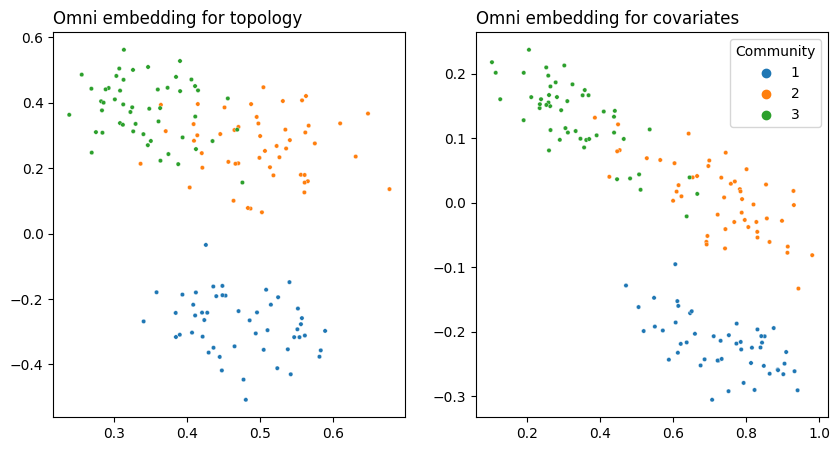

In [32]:
from graphbook_code import plot_latents

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# network
network_plot = plot_latents(joint_embedding[0], ax=axs[0], legend=None,
                            labels=labels, title="Omni embedding for topology")

# covariates
covariates_plot = plot_latents(joint_embedding[1], ax=axs[1], 
                               labels=labels, title="Omni embedding for covariates")

There's a few things going on here. First, you had to normalize the covariates by dividing $YY^\top$ by its maximum. This is because if you didn't, the covariates and the adjacency matrix would contribute vastly different amounts of information to the omnibus matrix. You can see that by looking at the average value of $YY^\top$ compared to the average value of $A$:

In [ ]:
print(r"Mean of Y@Y.T:", f"{np.mean(Y@Y.T):.2f}")
print(r"Mean of A:", f"{np.mean(A):.2f}")

In [ ]:
print(r"Mean of normalized Y@Y.T:", f"{np.mean(YYt):.2f}")
print(r"Mean of A:", f"{np.mean(A):.2f}")

Remember the way this data is set up: you can separate the first community from the last two with the topology, you can separate the last community from the first two with the covariates, but you need both data sources to separate all three. 

Here, you can see that *both embeddings* are able to separate all three communities. This is because the Omnibus Embedding induces dependence on the latent positions it outputs. Remember that the off-diagonals of the Omnibus Matrix contain the averages of pairs of networks fed into it. These off-diagonal elements are responsible for some "information leakage": so the topology embedding contains information from the covariates, and the covariate embedding contains information from the topology.

## MASE Joint Embedding

Just like you can use the OMNI to do a joint embedding, you can also use MASE to do a joint embedding. This fundamentally comes down to the fact that both embeddings fundamentally just eat matrices as their input - whether those matrices are the adjacency matrix or $YY^\top$ doesn't really matter.

Just like OMNI, we'll quickly recap how MASE works here:
1. Take multiple networks,
2. Embed them all separately with ASE or LSE,
3. Concate the embeddings into a joint latent position matrix with a lot more dimensions, and
4. Embed that joint matrix.

The difference here is the same as with Omni -- you have the adjacency matrix (topology) and its covariates for a single network. So instead of embedding a bunch of adjacency matrices or Laplacians, you embed the adjacency matrix (or Laplacian) and the similarity matrix for the covariates $YY^\top$ separately, concatenate, and then embed again.

In [ ]:
from graspologic.embed import MultipleASE as MASE

# Remmeber that YY^T is still normalized!
mase = MASE(n_components=2)
joint_embedding = mase.fit_transform([A, YYt])

In [ ]:
# network
plot = plot_latents(joint_embedding, labels=labels,
                            title="MASE embedding")

As you can see, MASE lets you get fairly clear separation between communities. The covariates are still normalized, as with OMNI, so that they can contribute the same amount to the embedding as the adjacency matrix.


## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```
